In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import tifffile
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

In [2]:
import os
import numpy as np
import tifffile
import torch
from torch.utils.data import Dataset
from PIL import Image

In [9]:
class UNetDataset12MasksUntouched(Dataset):
    def __init__(self, image_files, image_dir, mask_dir, target_size=(128,128), augment=False):
        self.image_files = image_files
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.target_size = target_size
        self.augment = augment
        self.epsilon = 1e-8

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        mask_file = img_file.replace(".tif", ".png")

        img_path = os.path.join(self.image_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        # --- Check files exist ---
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask file not found: {mask_path}")

        # --- Load image ---
        img = tifffile.imread(img_path).astype(np.float32)

        # --- Keep 12 channels ---
        if img.ndim == 2:
            img = np.stack([img]*12, axis=-1)
        elif img.ndim == 3:
            if img.shape[-1] < 12:
                pad_width = 12 - img.shape[-1]
                img = np.concatenate([img, np.zeros((*img.shape[:2], pad_width), dtype=img.dtype)], axis=-1)
            elif img.shape[-1] > 12:
                img = img[..., :12]
            # else img.shape[-1] == 12 → fine, do nothing

        # --- Safe normalization ---
        img_max = np.max(img, axis=(0,1), keepdims=True)
        img_max[img_max == 0] = 1
        img = img / img_max

        # --- Resize all channels ---
        img_resized = []
        for ch in range(12):
            ch_img = Image.fromarray((img[..., ch]*255).astype(np.uint8))
            ch_img = ch_img.resize(self.target_size, Image.Resampling.BILINEAR)
            img_resized.append(np.array(ch_img, dtype=np.float32)/255.0)
        img = np.stack(img_resized, axis=-1)

        # --- Load mask (untouched) ---
        mask = Image.open(mask_path).convert("L")
        mask = mask.resize(self.target_size, Image.Resampling.NEAREST)
        mask = np.expand_dims(np.array(mask, dtype=np.float32), axis=-1)

        # --- Optional augmentation ---
        if self.augment:
            if np.random.rand() > 0.5:
                img = np.flip(img, axis=1).copy()
                mask = np.flip(mask, axis=1).copy()
            if np.random.rand() > 0.5:
                img = np.flip(img, axis=0).copy()
                mask = np.flip(mask, axis=0).copy()

        # --- Ensure contiguous memory (fix negative strides issue) ---
        img = np.ascontiguousarray(img)
        mask = np.ascontiguousarray(mask)

        # --- Convert to torch tensors ---
        img = torch.from_numpy(img).permute(2, 0, 1).float()  # (C,H,W)
        mask = torch.from_numpy(mask).squeeze(2).long()  # (H,W)  # (1,H,W)

        return img, mask

In [10]:
from torch.utils.data import DataLoader

image_dir = r"D:\cellula\task_2\data\images"
mask_dir  = r"D:\cellula\task_2\data\labels"
all_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])

split = int(0.8 * len(all_files))
train_files = all_files[:split]
val_files   = all_files[split:]

train_dataset = UNetDataset12MasksUntouched(train_files, image_dir, mask_dir, augment=True)
val_dataset   = UNetDataset12MasksUntouched(val_files, image_dir, mask_dir, augment=False)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)

# --- Test one batch ---
for imgs, masks in train_loader:
    print(imgs.shape, masks.shape)
    break


torch.Size([4, 12, 128, 128]) torch.Size([4, 128, 128])


In [11]:
import torch.nn as nn
from torchvision.models.segmentation import fcn_resnet50

# Load pretrained backbone
model_flask = fcn_resnet50(pretrained=True)

# Change first conv layer to accept 9-channel input
orig_conv = model_flask.backbone.conv1
model_flask.backbone.conv1 = nn.Conv2d(
    in_channels=12,
    out_channels=orig_conv.out_channels,
    kernel_size=orig_conv.kernel_size,
    stride=orig_conv.stride,
    padding=orig_conv.padding,
    bias=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_flask = model_flask.to(device)

In [12]:
# Example: DeepLabV3 or FCN
print(model_flask.backbone)

IntermediateLayerGetter(
  (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(

In [13]:
import torch

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_flask.parameters(), lr=1e-4)

In [14]:
num_epochs = 17

for epoch in range(num_epochs):
    model_flask.train()
    train_loss = 0.0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)        # (B, 9, H, W)
        masks = masks.to(device)      # (B, H, W)

        optimizer.zero_grad()
        outputs = model_flask(imgs)['out']  # (B, num_classes, H, W)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model_flask.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model_flask(imgs)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/17, Train Loss: 0.9824, Val Loss: 0.9786
Epoch 2/17, Train Loss: 0.5517, Val Loss: 0.7433
Epoch 3/17, Train Loss: 0.5835, Val Loss: 0.5023
Epoch 4/17, Train Loss: 0.4903, Val Loss: 0.3405
Epoch 5/17, Train Loss: 0.4045, Val Loss: 0.3216
Epoch 6/17, Train Loss: 0.3950, Val Loss: 0.2897
Epoch 7/17, Train Loss: 0.3261, Val Loss: 0.2840
Epoch 8/17, Train Loss: 0.3160, Val Loss: 0.3297
Epoch 9/17, Train Loss: 0.3227, Val Loss: 0.2548
Epoch 10/17, Train Loss: 0.2778, Val Loss: 0.2613
Epoch 11/17, Train Loss: 0.2569, Val Loss: 0.2431
Epoch 12/17, Train Loss: 0.2420, Val Loss: 0.2584
Epoch 13/17, Train Loss: 0.2692, Val Loss: 0.2594
Epoch 14/17, Train Loss: 0.2283, Val Loss: 0.2411
Epoch 15/17, Train Loss: 0.2311, Val Loss: 0.2639
Epoch 16/17, Train Loss: 0.2194, Val Loss: 0.2183
Epoch 17/17, Train Loss: 0.2133, Val Loss: 0.2127


In [15]:
# ----------------------------
def visualize_prediction_3to11(img, mask, pred, channels_to_rgb=[0,2,5], threshold=0.5):
    pred_binary = (pred[...,0] > threshold).astype(np.float32) if pred.ndim==3 else pred
    rgb_img = img[..., channels_to_rgb]
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max()-rgb_img.min()+1e-8)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(rgb_img); plt.title("Input Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(mask[...,0] if mask.ndim==3 else mask, cmap='gray'); plt.title("GT Mask"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(pred_binary, cmap='gray'); plt.title("Pred Mask"); plt.axis("off")
    plt.show()

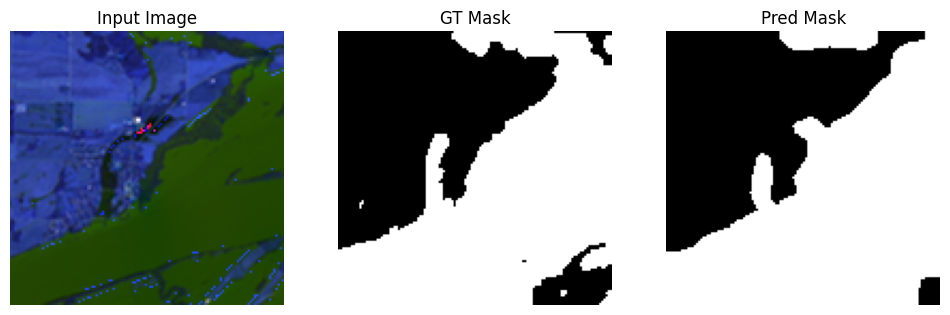

In [16]:
model_flask.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = model_flask(imgs)['out']
        preds = torch.argmax(outputs, dim=1)  # (B,H,W)

        # visualize first sample
        import numpy as np
        img_np = imgs[0].cpu().numpy().transpose(1,2,0)  # (H,W,9)
        true_mask = masks[0].cpu().numpy()
        pred_mask = preds[0].cpu().numpy()

        visualize_prediction_3to11(img_np, true_mask, pred_mask[...,None], channels_to_rgb=[0,2,5], threshold=0.5)
        break


In [20]:
import matplotlib.pyplot as plt
import torch

def visualize_prediction(model, img_tensor, mask_tensor=None, device='cuda', channels_to_rgb=[0,1,2]):
    """
    Visualize a single image prediction for a segmentation model.

    Parameters:
    -----------
    model : torch.nn.Module
        Your trained segmentation model.
    img_tensor : torch.Tensor
        Input image tensor, shape [C,H,W] or [1,C,H,W].
    mask_tensor : torch.Tensor or None
        Ground truth mask, shape [H,W]. Optional.
    device : str
        'cuda' or 'cpu'
    channels_to_rgb : list
        Which channels to use for RGB visualization, default first 3 channels.
    """
    model.eval()
    # Ensure batch dimension
    if img_tensor.ndim == 3:
        img_tensor = img_tensor.unsqueeze(0)  # [1,C,H,W]
    
    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        output = model(img_tensor)['out']  # [1,num_classes,H,W]
        pred = torch.argmax(output, dim=1).squeeze(0).cpu()  # [H,W]

    # Prepare RGB visualization from selected channels
    img_vis = img_tensor[0, channels_to_rgb, :, :].cpu().permute(1,2,0).numpy()
    
    plt.figure(figsize=(15,5))
    
    # Input image
    plt.subplot(1,3,1)
    plt.imshow(img_vis)
    plt.title("Input (channels {})".format(channels_to_rgb))
    plt.axis('off')
    
    # Ground truth mask
    if mask_tensor is not None:
        plt.subplot(1,3,2)
        plt.imshow(mask_tensor.cpu(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
    
    # Predicted mask
    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.show()


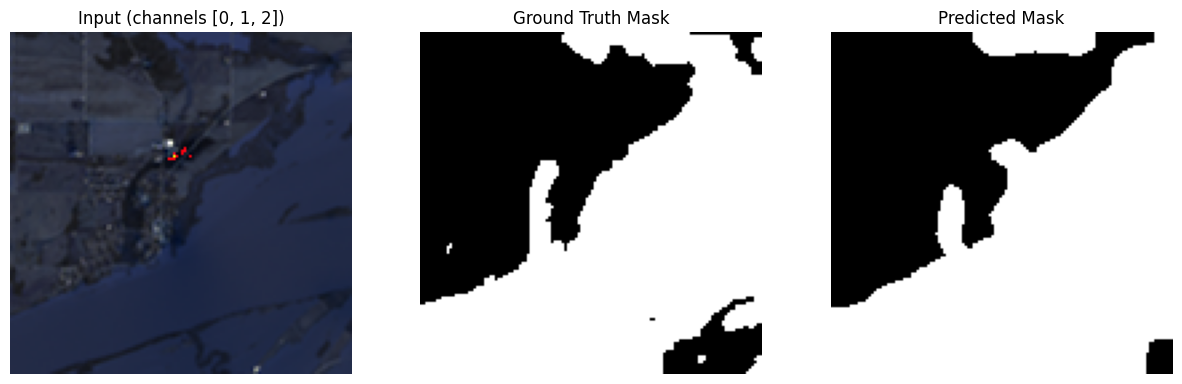

In [21]:
# Get a sample from validation set
imgs, masks = next(iter(val_loader))  # imgs: [B,12,H,W], masks: [B,H,W]


# Visualize first sample
visualize_prediction(model_flask, imgs[0], masks[0], device=device, channels_to_rgb=[0,1,2])


In [22]:
torch.save(model_flask.state_dict(), "segmentation_model.pth")